# Predicting the Risk of Diabetes in Pregnant Women

Authors: 
- Angela Yang
- Tina Chen
- Tom Cui 
- Yiyang Zhang

### Introduction: ###

Diabetes is a chronic health condition where blood glucose is unable to enter cells due to the lack of insulin facilitating this exchange (NIDDK, 2016). With diabetes being one of the top causes of death in North America (CDC, 2022), the need to determine the best health indicators becomes increasingly important for the correct diagnosis of diabetes. This study uses a dataset from Kaggle, originally from the National Institute of Diabetes and Digestive and Kidney Diseases, showing a variety of health indicators (e.g. blood pressure, Body Mass Index/BMI, glucose, insulin) and whether they were diagnosed with diabetes. 

For our project, we will try to answer this predictive question: Given the health profile of a patient, how accurate can our classification model predict potential diabetes cases based on the selected explanatory variables?

In [2]:
library(tidyverse)
library(repr)
library(tidymodels)
library(gridExtra)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
diabetes_data <- read_csv("data/diabetes.csv")
diabetes_data

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
0,137,40,35,168,43.1,2.288,33,1
5,116,74,0,0,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,0,0,0,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1


In [4]:
diabetes_data <- diabetes_data |>
    mutate(Outcome = as_factor(Outcome)) |>
    filter(Pregnancies!=0)

diabetes_data_processed <- diabetes_data |>
    mutate(
        Glucose=ifelse(Glucose==0,NA,Glucose),
        BloodPressure=ifelse(BloodPressure==0,NA,BloodPressure),
        SkinThickness=ifelse(SkinThickness==0,NA,SkinThickness),
        Insulin=ifelse(Insulin==0,NA,Insulin),
        BMI=ifelse(BMI==0,NA,BMI),
        DiabetesPedigreeFunction=ifelse(DiabetesPedigreeFunction==0,NA,DiabetesPedigreeFunction))
diabetes_data_processed

nrow(diabetes_data)

Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,1
1,85,66,29,NA,26.6,0.351,31,0
8,183,64,NA,NA,23.3,0.672,32,1
1,89,66,23,94,28.1,0.167,21,0
5,116,74,NA,NA,25.6,0.201,30,0
3,78,50,32,88,31.0,0.248,26,1
10,115,NA,NA,NA,35.3,0.134,29,0
2,197,70,45,543,30.5,0.158,53,1
8,125,96,NA,NA,NA,0.232,54,1


[1] 657

In [5]:
set.seed(1400)

diabetes_split <- initial_split(diabetes_data, prop = 0.76, strata = Outcome)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split)

In [6]:
diabetes_train |>
    group_by(Outcome) |>
    summarize(count = n())

Outcome,count
<fct>,<int>
0,324
1,174


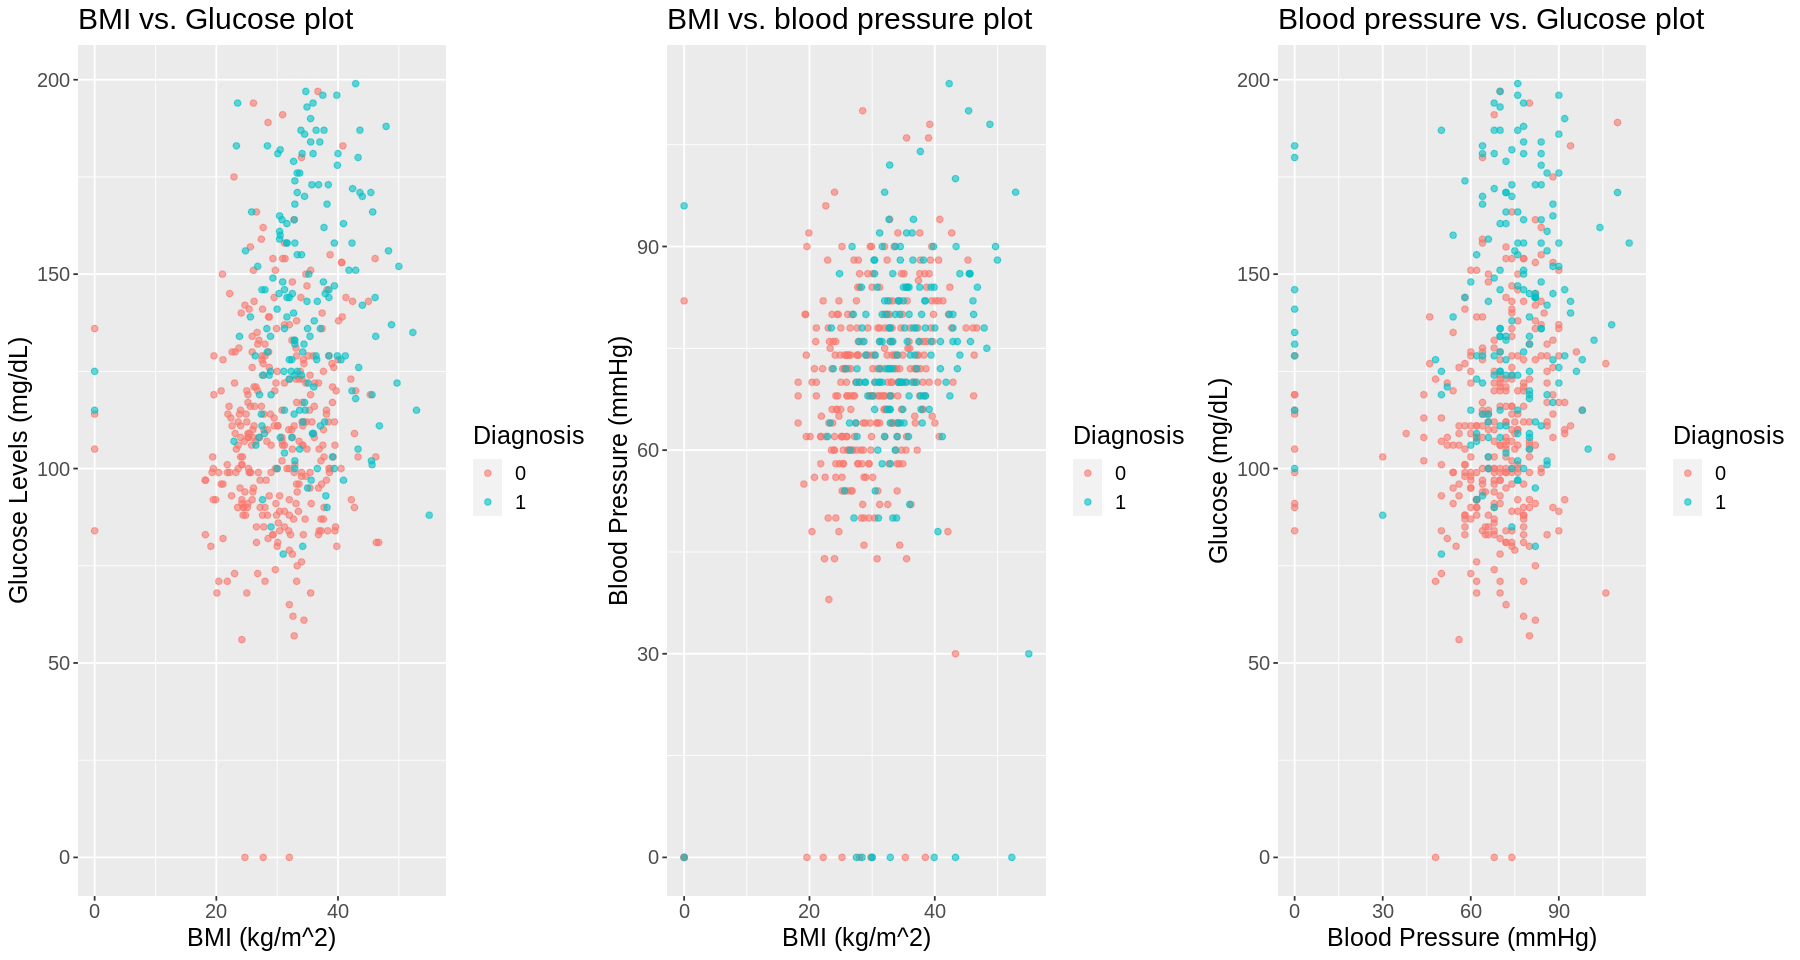

In [7]:
options(repr.plot.width = 15, repr.plot.height = 8)

BMIGlucose_plot <- ggplot(diabetes_train, aes(x = BMI, y = Glucose, color = Outcome)) +
  geom_point(alpha = 0.6) +
  labs(x = "BMI (kg/m^2)", 
       y = "Glucose Levels (mg/dL)",
       color = "Diagnosis") +
ggtitle("BMI vs. Glucose plot") +
theme(text = element_text(size = 15))

BMIBloodpressure_plot <- ggplot(diabetes_train, aes(x = BMI, y = BloodPressure, color = Outcome)) +
  geom_point(alpha = 0.6) +
  labs(x = "BMI (kg/m^2)", 
       y = "Blood Pressure (mmHg)",
       color = "Diagnosis") +
ggtitle("BMI vs. blood pressure plot") +
theme(text = element_text(size = 15))

BloodpressureGlucose_plot <- ggplot(diabetes_train, aes(x = BloodPressure, y = Glucose, color = Outcome)) +
  geom_point(alpha = 0.6) +
  labs(x = "Blood Pressure (mmHg)", 
       y = "Glucose (mg/dL)",
       color = "Diagnosis") +
ggtitle("Blood pressure vs. Glucose plot") +
theme(text = element_text(size = 15))

grid.arrange(BMIGlucose_plot, BMIBloodpressure_plot, BloodpressureGlucose_plot,
             layout_matrix = rbind(c(1, 2, 3),
                                   c(1, 2, 3)))

In [8]:
diabetes_recipe <- recipe(Outcome ~ BMI + Glucose, data = diabetes_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
diabetes_recipe

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

In [ ]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1)) 

diabetes_vfold <- vfold_cv(data = diabetes_train, v = 5, strata = Outcome)

knn_results <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = diabetes_vfold, grid = k_vals) |>
    collect_metrics()

accuracies <- knn_results |>
    filter(.metric == "accuracy")

accuracies_vs_k_plot <- ggplot(accuracies, aes(x=neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbours", y="Accuracy Estimate")
accuracies_vs_k_plot

As seen from the plot, we should use K = 7 because its accuracy estimate is the highest and the line plateaus past 7. This K will be used in building our final, most accurate model for classification. 

In [10]:
diabetes_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")
diabetes_spec

diabetes_fit <- workflow() |>
    add_recipe(diabetes_recipe) |>
    add_model(diabetes_spec) |>
    fit(data = diabetes_train)
diabetes_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 7
  weight_func = rectangular

Computational engine: kknn 


══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(7,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2550201
Best kernel: rectangular
Best k: 7

In [13]:
diabetes_test_predictions <- predict(diabetes_fit, diabetes_test) |>
    bind_cols(diabetes_test)
diabetes_test_predictions

.pred_class,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,6,148,72,35,0,33.6,0.627,50,1
0,1,89,66,23,94,28.1,0.167,21,0
1,2,197,70,45,543,30.5,0.158,53,1
1,10,168,74,0,0,38.0,0.537,34,1
0,10,139,80,0,0,27.1,1.441,57,0
1,1,189,60,23,846,30.1,0.398,59,1
0,7,107,74,0,0,29.6,0.254,31,1
0,1,97,66,15,140,23.2,0.487,22,0
0,10,122,78,31,0,27.6,0.512,45,0


In [17]:
diabetes_test_predictions |>
    metrics(truth = Outcome, estimate = .pred_class) |>
    filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7232704


From this, it can be seen that the accuracy of our classification model is 72.3%. Future ways this classification model can be improved include...

Next, this classification system will be applied to a makeshift scenario where an individual has a BMI of 40.2 and glucose level of 150. The following is the code to classify whether this person has diabetes or not.

### Methods: ###